In [1]:
import requests
import pandas as pd
import io
import re

import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
metadata_df = pd.read_csv('selected_diffusion_rate.csv')

In [5]:
dfs_dict = {}

In [6]:
def get_df_from_url(url):
    match_ = re.match("https\:\/\/docs\.google\.com/spreadsheets/d/(\S+)/edit\?usp\=sharing", url)
    if match_:
        google_sheet_id = match_.groups(0)[0]
    else:
        print(url, "error")
        return False
    requests_url = f"https://docs.google.com/spreadsheets/d/{google_sheet_id}/export?format=csv"
    response = requests.get(requests_url)
    exp_df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    return exp_df

In [7]:
for row in metadata_df.itertuples():
    key = (row.rxn_id, row.solvent, row.cation, 'crystallization')
    if key in dfs_dict:
        # already processed
        continue
    crystal_url = row.crystal_growth_data_location
    if not pd.isnull(crystal_url):
        crystal_df = get_df_from_url(crystal_url)
        if crystal_df is False:
            print('error', crystal_url)
        dfs_dict[key] = crystal_df
        
        # get the diffusion data
        key = (row.rxn_id, row.solvent, row.cation, 'diffusion')
        diffusion_df = get_df_from_url(row.diffusion_data_location)
        dfs_dict[key] = diffusion_df
        
        

In [8]:
dfs_dict.keys()

dict_keys([('MA_333_1', 'DMF', '2Pyrrolidin1ium1ylethylammoniumiodide', 'crystallization'), ('MA_333_1', 'DMF', '2Pyrrolidin1ium1ylethylammoniumiodide', 'diffusion'), ('MA_333_3', 'DMF:DMSO', '2Pyrrolidin1ium1ylethylammoniumiodide', 'crystallization'), ('MA_333_3', 'DMF:DMSO', '2Pyrrolidin1ium1ylethylammoniumiodide', 'diffusion'), ('MA_333_4', 'GBL:DMF', '2Pyrrolidin1ium1ylethylammoniumiodide', 'crystallization'), ('MA_333_4', 'GBL:DMF', '2Pyrrolidin1ium1ylethylammoniumiodide', 'diffusion'), ('MA_336_4', 'GBL', 'CyclohexylmethylammoniumIodide', 'crystallization'), ('MA_336_4', 'GBL', 'CyclohexylmethylammoniumIodide', 'diffusion'), ('MA_337_2', 'DMF:DMSO', 'PiperazinediiumDiodide', 'crystallization'), ('MA_337_2', 'DMF:DMSO', 'PiperazinediiumDiodide', 'diffusion'), ('MA_337_5', 'DMSO', 'PiperazinediiumDiodide', 'crystallization'), ('MA_337_5', 'DMSO', 'PiperazinediiumDiodide', 'diffusion'), ('MA_350_1', 'GBL', 'AcNH3I', 'crystallization'), ('MA_350_1', 'GBL', 'AcNH3I', 'diffusion'), ('M

In [9]:
dfs_list = []
for key, df in dfs_dict.items():
    rxn_id, solvent, cation, analysis = key
#     if analysis != 'diffusion':
#         break
    df['rxn_id'] = rxn_id
    df['solvent'] = solvent
    df['cation'] = cation
    df['analysis'] = analysis
    dfs_list.append(df)

In [10]:
len(dfs_list)

46

In [11]:
df = pd.concat(dfs_list)

/Users/nick.leiby/.virtualenvs/perovskites/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [63]:
# select only data for solvent tube
solvent_df = df[df.measurement_name == 'solvent']

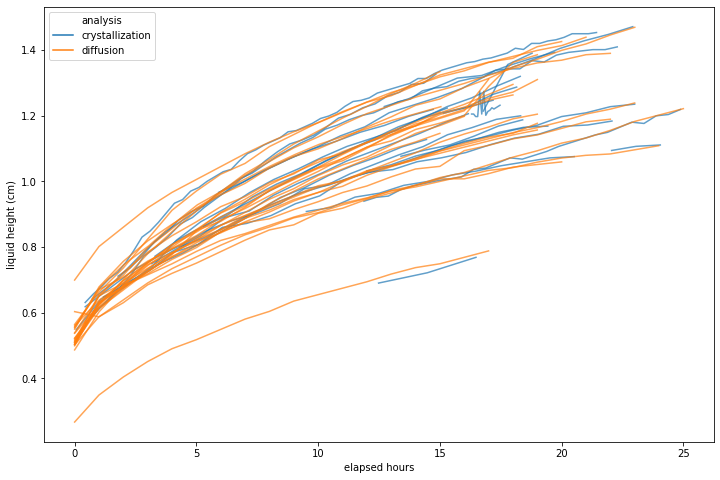

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', hue='analysis', estimator=None, data=solvent_df, ax=ax, alpha=0.7)

In [65]:
crystal_first_observed_time = pd.DataFrame(solvent_df[solvent_df.analysis=='crystallization'].groupby('rxn_id').min()['elapsed hours']).reset_index()

In [67]:
diffusion_df = solvent_df[solvent_df.analysis=='diffusion']
diffusion_df = diffusion_df.merge(crystal_first_observed_time, left_on='rxn_id', right_on='rxn_id', suffixes=['', ' since_start'])
diffusion_df['crystal_formed'] = diffusion_df['elapsed hours'] >= diffusion_df['elapsed hours since_start']
diffusion_df.reset_index(drop=True, inplace=True)

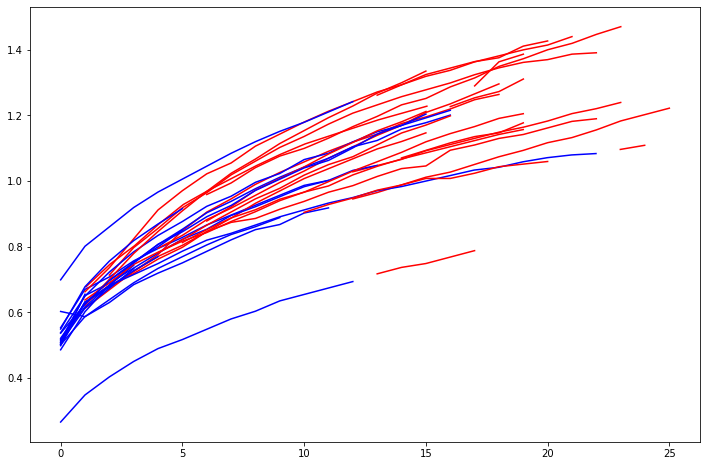

In [69]:
fig, ax = plt.subplots(figsize=(12,8))
for rxn_id, row_inds in diffusion_df.groupby('rxn_id').groups.items():
    subdf = diffusion_df.iloc[row_inds]
    crystal_mask = subdf['crystal_formed']
    
    ax.plot(subdf.loc[crystal_mask, 'elapsed hours'], subdf.loc[crystal_mask, 'liquid height (cm)'], 'r')
    ax.plot(subdf.loc[~crystal_mask, 'elapsed hours'], subdf.loc[~crystal_mask, 'liquid height (cm)'], 'b')

# sns.lineplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', hue='crystal_formed', estimator=None, data=diffusion_df, ax=ax, alpha=0.7)

Text(0, 0.5, 'Solvent height (cm)')

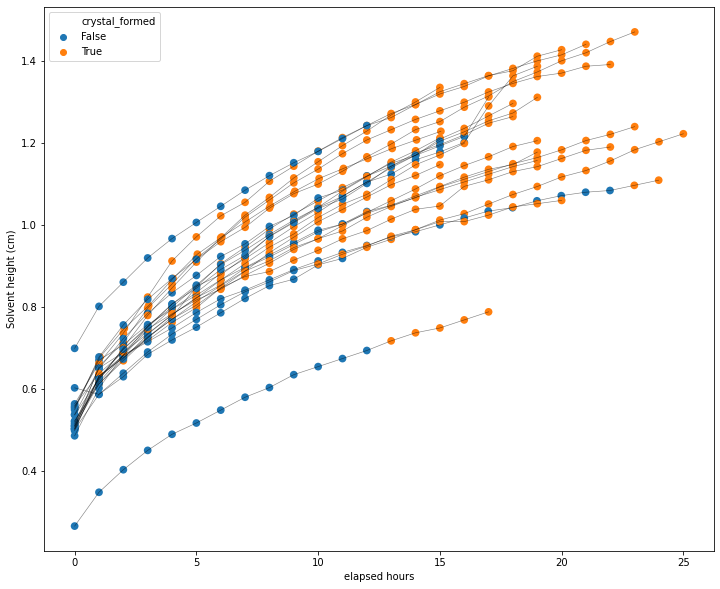

In [97]:
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', estimator=None, data=diffusion_df, ax=ax, color='k', alpha=0.5, linewidth=0.6)
sns.scatterplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', hue='crystal_formed', estimator=None, data=diffusion_df, ax=ax, s=60, linewidth=0)
ax.set_ylabel("Solvent height (cm)")

In [100]:
diffusion_df['solvent'].unique()

array(['DMF', 'DMF:DMSO', 'GBL:DMF', 'GBL', 'DMSO'], dtype=object)

In [103]:
axes[i]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd69991f5f8>,
      dtype=object)

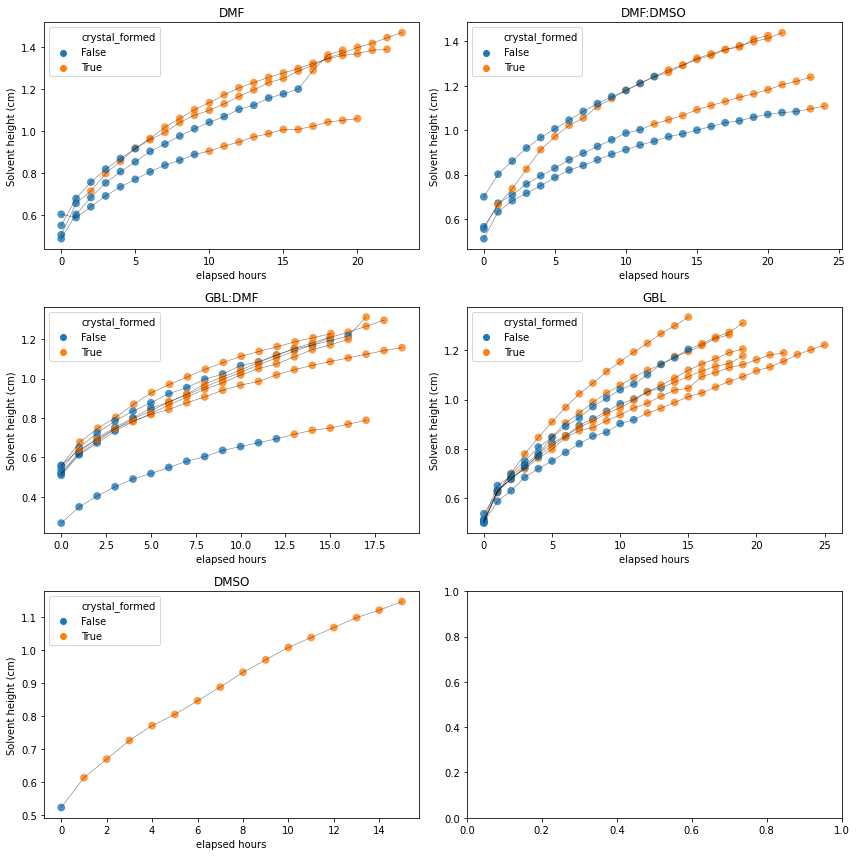

In [107]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))
for i, solvent in enumerate(diffusion_df['solvent'].unique()):
    ax = axes.flatten()[i]
    subdf = diffusion_df[diffusion_df.solvent == solvent]
    sns.lineplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', estimator=None, data=subdf, ax=ax, color='k', alpha=0.5, linewidth=0.6)
    sns.scatterplot(x='elapsed hours', y='liquid height (cm)', units='rxn_id', hue='crystal_formed', estimator=None, data=subdf, ax=ax, s=60, linewidth=0, alpha=0.8)
    ax.set_ylabel("Solvent height (cm)")
    ax.set_title(solvent)
fig.tight_layout()

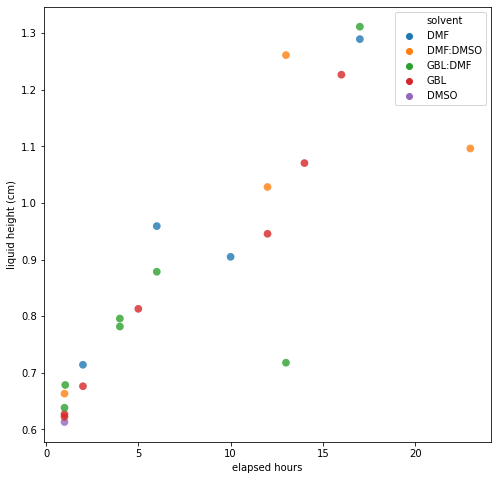

In [119]:
fig, ax = plt.subplots(figsize=(8,8))
data = diffusion_df[diffusion_df.crystal_formed].sort_values('elapsed hours').groupby('rxn_id').nth(0)
sns.scatterplot(x='elapsed hours', y='liquid height (cm)', hue='solvent', data=data, ax=ax, s=60, linewidth=0, alpha=0.8)


Text(0.5, 1.0, 'Distribution of elapsed time until crystal nucleation')

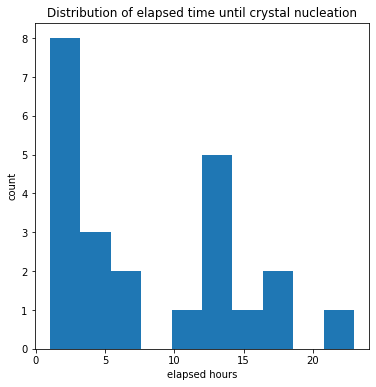

In [126]:
fig, ax = plt.subplots(figsize=(6,6))
data = diffusion_df[diffusion_df.crystal_formed].sort_values('elapsed hours').groupby('rxn_id').nth(0)
ax.hist(data['elapsed hours'])
ax.set_xlabel('elapsed hours')
ax.set_ylabel('count')

ax.set_title("Distribution of elapsed time until crystal nucleation")

Text(0.5, 1.0, 'Distribution of diffusion amount (solvent liquid height) until crystal nucleation')

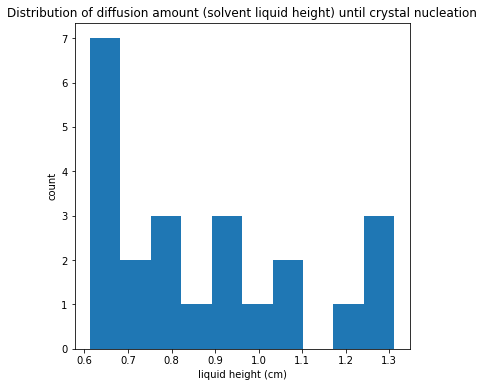

In [127]:
fig, ax = plt.subplots(figsize=(6,6))
data = diffusion_df[diffusion_df.crystal_formed].sort_values('elapsed hours').groupby('rxn_id').nth(0)
ax.hist(data['liquid height (cm)'])
ax.set_xlabel('liquid height (cm)')
ax.set_ylabel('count')
ax.set_title("Distribution of diffusion amount (solvent liquid height) until crystal nucleation")